# Pipeline Summary

### This pipeline is able to:

- Using NLTK libraries to break down words from reviews into tokens so computers can understand.
Then, redundant words are removed to pick out the most important topics.
- VADER (Sentiment Analyzer of NLTK) will give out sentiment scores based on token words.
<br>**Pros:** Short Processing Time
<br>**Cons:** Does not pick up context or sarcasm
- ROBERTA (Pretrained ML model for NLP): will give out the same sentiment scores as VADER
<br>**Pros:** Current one of the most advanced ML for NLP. Picks up context and sarcasm
<br>**Cons:** Longer Processing Time ( 5 minutes for 7000 values).
- Hugging Face Pipeline: Give Out Label, from 1 - 5, same value as regular rating, 1 is the most negative and 5 is the most positive. Sentiment_score means accuracy percentage
<br>**Pros:** Easy to set up and picks up context
<br>**Cons:** Processing time might be longer than 5 minutes. Difficult for decision-making where the accuracy of model is low.

### Questions solving ability:

- What is the ratio of positive and negative sentiments towards these products? <br>
The answer is in **Section 2.5 and 2.6**

- Are there any recurring themes in positive and negative comments? <br>
The Answer is in **section 3**

- What are the analytics across various social signals from website feedback, google reviews, amazon/walmart ecomm websites, social media like facebook or Twitter? <br>
We now have Amazon + iherb for analaysis

# Import Libraries

In [87]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud
from collections import Counter
import nltk
from tqdm.notebook import tqdm
import seaborn as sns
import torch.nn.functional as F

nltk.download('wordnet')
filterwarnings('ignore')
plt.style.use('ggplot')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

# Loading Data and EDA

In [88]:
# Read in data
neuriva_stress = pd.read_csv('neuriva_brain_destress_iherb.csv')
neuriva_org = pd.read_csv('neuriva_brain_original_iherb.csv')
neuriva_plus = pd.read_csv('neuriva_brain_plus_iherb.csv')
swanson = pd.read_csv('swanson_coffee_cherry_iherb.csv')
df = pd.concat([neuriva_stress, neuriva_org, neuriva_plus, swanson], ignore_index=True)
print(df.shape)

(307, 6)


In [89]:
# Assuming your DataFrame is named "df" and the column is named "comment"
df['review_body'] = df['review_body'].str.replace("â€™", "'", regex=False)

In [90]:
df.head()

,product,date,person,rating,title,review_body
0,"Page 1 - Reviews - Swanson, Full Spectrum Coff...","Posted on Sep 13, 2023",Naetgirl,5,"Love Swanson, great calibre of supplements. Ve...",I have been using Swanson products for over a ...
1,"Page 1 - Reviews - Swanson, Full Spectrum Coff...","Posted on Sep 1, 2023",iHerb Customer,5,It Works!,Coffee cherry extract is highly recommended by...
2,"Page 1 - Reviews - Swanson, Full Spectrum Coff...","Posted on Nov 27, 2023",iHerb Customer,5,Good quality,"I feel more energised, and the brain fog has r..."
3,"Page 1 - Reviews - Swanson, Full Spectrum Coff...","Posted on Apr 17, 2024",iHerb Customer,5,A real boost,If I take one of these in the morning without ...
4,"Page 1 - Reviews - Swanson, Full Spectrum Coff...","Posted on Jan 9, 2024",iHerb Customer,5,The best option,This coffee cherry supplement is one of the be...


In [91]:
#Checking how many product in the data set to do different analysis.
# unique_products = df['product_name'].unique()
# print(unique_products)

In [92]:
#Missing Values:

missing_values = df.isnull().sum()
# Create a DataFrame from the missing_values Series
missing_values_df = pd.DataFrame(missing_values, columns=['Missing Values'])

# Set display option to show all rows
pd.set_option('display.max_rows', None)

# Print the DataFrame
print(missing_values_df)

             Missing Values
product                   0
date                      0
person                    0
rating                    0
title                   154
review_body               0


In [93]:
# Filled NA for title column
df['title'].fillna('best of the best', inplace=True)

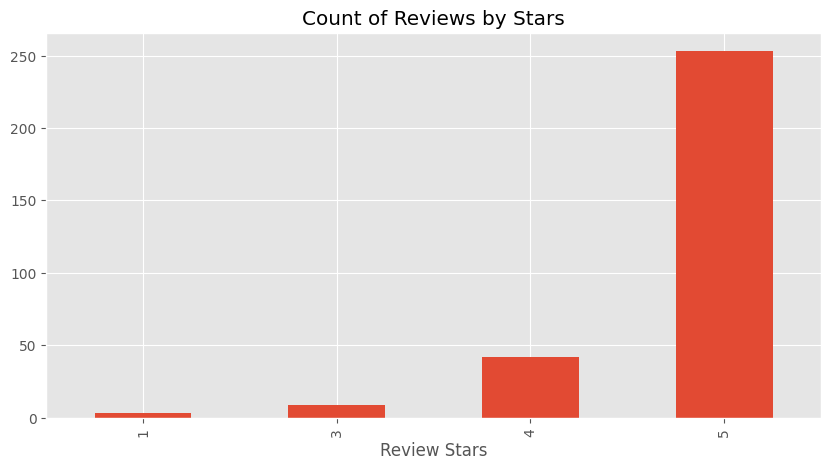

In [94]:
ax = df['rating'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

# Basic Natural Language Toolkit (NLTK)

In [95]:
#Testing on an text example

example = df['review_body'][10]
print(example)

I cannot say it is good, i cannot say it is bad either. I just don’t feel anything. What I can say for sure is that it is definitely not a stimulant. The bottle says antioxidant support not energy. It should however contain a tiny amount of caffeine


In [96]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['I', 'can', 'not', 'say', 'it', 'is', 'good', ',', 'i', 'can']

In [97]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('I', 'PRP'),
 ('can', 'MD'),
 ('not', 'RB'),
 ('say', 'VB'),
 ('it', 'PRP'),
 ('is', 'VBZ'),
 ('good', 'JJ'),
 (',', ','),
 ('i', 'NNS'),
 ('can', 'MD')]

In [98]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  I/PRP
  can/MD
  not/RB
  say/VB
  it/PRP
  is/VBZ
  good/JJ
  ,/,
  i/NNS
  can/MD
  not/RB
  say/VB
  it/PRP
  is/VBZ
  bad/JJ
  either/RB
  ./.
  I/PRP
  just/RB
  don/VB
  ’/JJ
  t/NN
  feel/NN
  anything/NN
  ./.
  What/WP
  I/PRP
  can/MD
  say/VB
  for/IN
  sure/JJ
  is/VBZ
  that/IN
  it/PRP
  is/VBZ
  definitely/RB
  not/RB
  a/DT
  stimulant/NN
  ./.
  The/DT
  bottle/NN
  says/VBZ
  antioxidant/JJ
  support/NN
  not/RB
  energy/NN
  ./.
  It/PRP
  should/MD
  however/RB
  contain/VB
  a/DT
  tiny/JJ
  amount/NN
  of/IN
  caffeine/NN)


In [99]:
nltk.download('stopwords') #Run this if stopwords does not run

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [100]:
import nltk

# Tokenization and removing stopwords
stop_words = set(stopwords.words('english'))

def tokenize_text(text):
    words = word_tokenize(text.lower())
    filtered_words = [word for word in words if word.isalnum() and word not in stop_words]
    return filtered_words

# Tokenize review_body column
df['tokenized'] = df['review_body'].apply(tokenize_text)

# Text Visualization

In [101]:
# Calculation of Term Frequencies
tf = df["tokenized"].apply(lambda x: pd.value_counts(x)).sum(axis=0).reset_index()
tf.columns = ["words", "tf"]
tf.head()

,words,tf
0,brain,55.0
1,time,27.0
2,sleep,19.0
3,using,17.0
4,enough,7.0


In [102]:
tf.shape

(798, 2)

In [103]:
tf["words"].nunique()

798

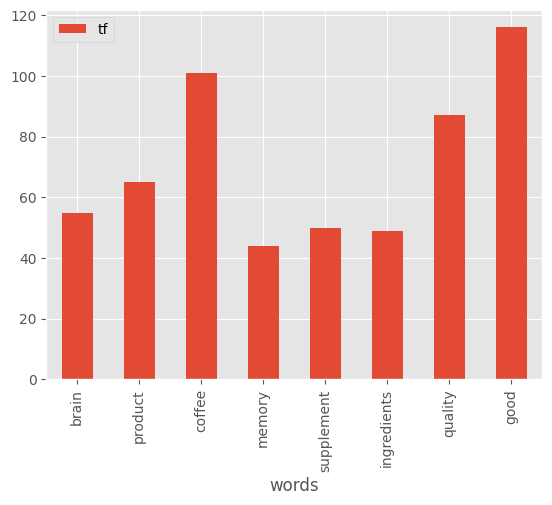

In [104]:
#Words that appear more than 5 times, we can update when we have bigger data set
tf[tf["tf"] > 40].plot.bar(x="words", y="tf")
plt.show()

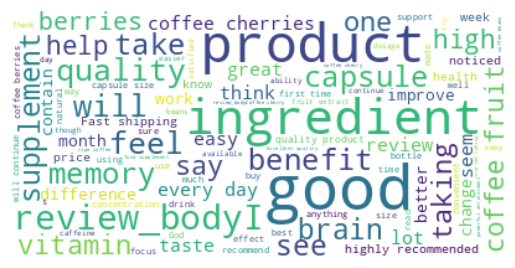

In [105]:
text = "review_body".join(i for i in df.review_body)
wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Step 1. VADER Seniment Scoring (This is an old method as a reference, will focus more on Roberta)

We will use NLTK's Sentiment Itensity Analyzer to get the neg/neu/pos scores of the text.
This uses a "bag of words" approach:
1. Stop words are removed
2. each word is scored and combined to a total score.

In [106]:
from nltk.sentiment import SentimentIntensityAnalyzer#
from tqdm.notebook import tqdm
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [107]:
ids = range(1, len(df) + 1)

# Insert the 'id' column at the beginning of the DataFrame
df.insert(0, 'id', ids)

### Vader Scoring for review_body

In [108]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['review_body']
    myid = row['id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/307 [00:00<?, ?it/s]

In [109]:
vaders1 = pd.DataFrame(res).T
vaders1 = vaders1.reset_index().rename(columns={'index': 'id'})
vaders1 = vaders1.merge(df, how='left')

In [110]:
vaders1.head()

,id,neg,neu,pos,compound,product,date,person,rating,title,review_body,tokenized
0,1,0.00,0.866,0.134,0.8689,"Page 1 - Reviews - Swanson, Full Spectrum Coff...","Posted on Sep 13, 2023",Naetgirl,5,"Love Swanson, great calibre of supplements. Ve...",I have been using Swanson products for over a ...,"[using, swanson, products, decade, trustworthy..."
1,2,0.04,0.788,0.172,0.8974,"Page 1 - Reviews - Swanson, Full Spectrum Coff...","Posted on Sep 1, 2023",iHerb Customer,5,It Works!,Coffee cherry extract is highly recommended by...,"[coffee, cherry, extract, highly, recommended,..."
2,3,0.00,0.827,0.173,0.8872,"Page 1 - Reviews - Swanson, Full Spectrum Coff...","Posted on Nov 27, 2023",iHerb Customer,5,Good quality,"I feel more energised, and the brain fog has r...","[feel, energised, brain, fog, receded, bot, si..."
3,4,0.00,0.717,0.283,0.8342,"Page 1 - Reviews - Swanson, Full Spectrum Coff...","Posted on Apr 17, 2024",iHerb Customer,5,A real boost,If I take one of these in the morning without ...,"[take, one, morning, without, drinking, anythi..."
4,5,0.00,0.718,0.282,0.8957,"Page 1 - Reviews - Swanson, Full Spectrum Coff...","Posted on Jan 9, 2024",iHerb Customer,5,The best option,This coffee cherry supplement is one of the be...,"[coffee, cherry, supplement, one, best, option..."


### Vader Scoring For Title

In [111]:
res2 = {}
for index, row in df.iterrows():
    text = str(row['title'])  # Convert to string
    myid = row['id']
    res2[myid] = sia.polarity_scores(text)

In [112]:
for key, value in res2.items():
    value['neg_title'] = value.pop('neg')
    value['neu_title'] = value.pop('neu')
    value['pos_title'] = value.pop('pos')
    value['compound_title'] = value.pop('compound')

In [113]:
vaders = pd.DataFrame(res2).T
vaders = vaders.reset_index().rename(columns={'index': 'id'})
vaders = vaders.merge(vaders1, how='left')

In [114]:
vaders['neu_title'][8]

0.192

In [115]:
vaders.head()

,id,neg_title,neu_title,pos_title,compound_title,neg,neu,pos,compound,product,date,person,rating,title,review_body,tokenized
0,1,0.0,0.291,0.709,0.9216,0.00,0.866,0.134,0.8689,"Page 1 - Reviews - Swanson, Full Spectrum Coff...","Posted on Sep 13, 2023",Naetgirl,5,"Love Swanson, great calibre of supplements. Ve...",I have been using Swanson products for over a ...,"[using, swanson, products, decade, trustworthy..."
1,2,0.0,1.000,0.000,0.0000,0.04,0.788,0.172,0.8974,"Page 1 - Reviews - Swanson, Full Spectrum Coff...","Posted on Sep 1, 2023",iHerb Customer,5,It Works!,Coffee cherry extract is highly recommended by...,"[coffee, cherry, extract, highly, recommended,..."
2,3,0.0,0.256,0.744,0.4404,0.00,0.827,0.173,0.8872,"Page 1 - Reviews - Swanson, Full Spectrum Coff...","Posted on Nov 27, 2023",iHerb Customer,5,Good quality,"I feel more energised, and the brain fog has r...","[feel, energised, brain, fog, receded, bot, si..."
3,4,0.0,0.270,0.730,0.4019,0.00,0.717,0.283,0.8342,"Page 1 - Reviews - Swanson, Full Spectrum Coff...","Posted on Apr 17, 2024",iHerb Customer,5,A real boost,If I take one of these in the morning without ...,"[take, one, morning, without, drinking, anythi..."
4,5,0.0,0.323,0.677,0.6369,0.00,0.718,0.282,0.8957,"Page 1 - Reviews - Swanson, Full Spectrum Coff...","Posted on Jan 9, 2024",iHerb Customer,5,The best option,This coffee cherry supplement is one of the be...,"[coffee, cherry, supplement, one, best, option..."


### The combination score

In [116]:
vaders['compound_score'] = (vaders['compound'] + vaders['compound_title']) / 2

In [117]:
vaders['title'][8]

'best of the best'

In [118]:
#vaders.to_csv('amazon_vaders.csv', index=False)

## Plot Vader Results

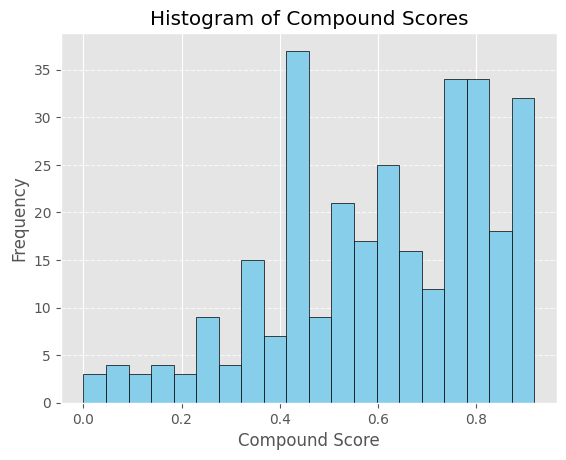

In [119]:
vaders['compound_score'].plot.hist(bins=20, color='skyblue', edgecolor='black')

plt.xlabel('Compound Score')
plt.ylabel('Frequency')
plt.title('Histogram of Compound Scores')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

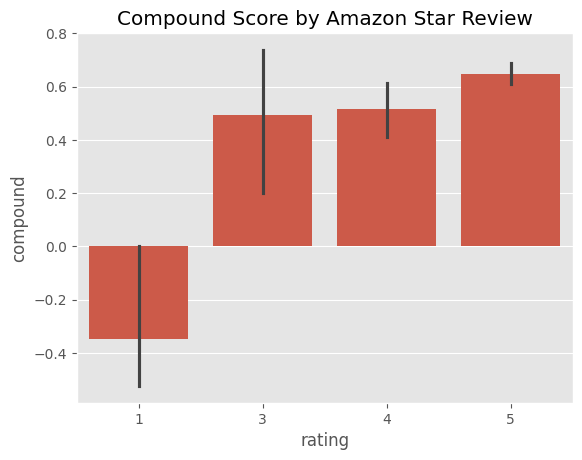

In [120]:
ax = sns.barplot(data=vaders, x='rating', y='compound')
ax.set_title('Compound Score by Amazon Star Review')
plt.show()

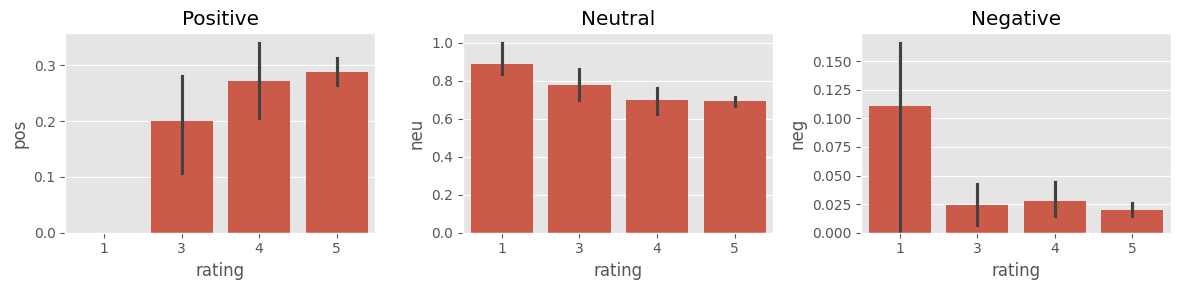

In [121]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='rating', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='rating', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='rating', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

The above graphs shows there is a small difference between rating and scroing from Vaders.
<br> - For example, in the Positive graph, the total score of 5 star should have a higher score than 4 star
<br> - The same goes with the last negative graph, where the total score for negative of 3 star should be the highest, but 4 star takes over.

# Step 2: Roberta Pretrained Model

### 2.1. Building model and sample test

In [122]:
#pip install torch torchvision

In [123]:
#pip install transformers

In [124]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [125]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [126]:
print(example)
sia.polarity_scores(example)

I cannot say it is good, i cannot say it is bad either. I just don’t feel anything. What I can say for sure is that it is definitely not a stimulant. The bottle says antioxidant support not energy. It should however contain a tiny amount of caffeine


{'neg': 0.102, 'neu': 0.693, 'pos': 0.204, 'compound': 0.647}

In [127]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.31241354, 'roberta_neu': 0.5059659, 'roberta_pos': 0.18162054}


In [128]:
def polarity_scores_roberta(text, text_type='review_body'):
    encoded_text = tokenizer(text, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    if text_type == 'review_body':
        scores_dict = {
            'roberta_neg' : scores[0],
            'roberta_neu' : scores[1],
            'roberta_pos' : scores[2]
        }
    elif text_type == 'title':
        scores_dict = {
            'roberta_title_neg' : scores[0],
            'roberta_title_neu' : scores[1],
            'roberta_title_pos' : scores[2]
        }
    else:
        raise ValueError("Invalid text type. It should be either 'review_body' or 'title'")

    return scores_dict

### 2.2. Running model for 'comment' and 'title'

In [129]:
res_roberta = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        comment_text = row['review_body']
        title_text = row['title']
        myid = row['id']

        comment_roberta_result = polarity_scores_roberta(comment_text, text_type='review_body')
        title_roberta_result = polarity_scores_roberta(title_text, text_type='title')

        both = {**comment_roberta_result, **title_roberta_result}
        res_roberta[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/307 [00:00<?, ?it/s]

In [130]:
results_df = pd.DataFrame(res_roberta).T
results_df = results_df.reset_index().rename(columns={'index': 'id'})
results_df = results_df.merge(df, how='left')
results_df.head()

,id,roberta_neg,roberta_neu,roberta_pos,roberta_title_neg,roberta_title_neu,roberta_title_pos,product,date,person,rating,title,review_body,tokenized
0,1,0.017194,0.217852,0.764953,0.003245,0.039447,0.957308,"Page 1 - Reviews - Swanson, Full Spectrum Coff...","Posted on Sep 13, 2023",Naetgirl,5,"Love Swanson, great calibre of supplements. Ve...",I have been using Swanson products for over a ...,"[using, swanson, products, decade, trustworthy..."
1,2,0.004275,0.075740,0.919985,0.005411,0.126771,0.867818,"Page 1 - Reviews - Swanson, Full Spectrum Coff...","Posted on Sep 1, 2023",iHerb Customer,5,It Works!,Coffee cherry extract is highly recommended by...,"[coffee, cherry, extract, highly, recommended,..."
2,3,0.007229,0.092513,0.900258,0.029416,0.325991,0.644593,"Page 1 - Reviews - Swanson, Full Spectrum Coff...","Posted on Nov 27, 2023",iHerb Customer,5,Good quality,"I feel more energised, and the brain fog has r...","[feel, energised, brain, fog, receded, bot, si..."
3,4,0.005101,0.088755,0.906144,0.007523,0.235972,0.756504,"Page 1 - Reviews - Swanson, Full Spectrum Coff...","Posted on Apr 17, 2024",iHerb Customer,5,A real boost,If I take one of these in the morning without ...,"[take, one, morning, without, drinking, anythi..."
4,5,0.001231,0.009891,0.988878,0.019781,0.310347,0.669871,"Page 1 - Reviews - Swanson, Full Spectrum Coff...","Posted on Jan 9, 2024",iHerb Customer,5,The best option,This coffee cherry supplement is one of the be...,"[coffee, cherry, supplement, one, best, option..."


In [131]:
print(results_df['roberta_title_pos'][8])
print(results_df['roberta_title_neu'][8])
print(results_df['roberta_title_neg'][8])

0.8922618
0.10237718
0.005361027


In [132]:
print(results_df['roberta_title_pos'][10])
print(results_df['roberta_title_neu'][10])
print(results_df['roberta_title_neg'][10])

0.8922618
0.10237718
0.005361027


__Since title has null value and has been replaced with a random string, we will need to convert those scores back to all 0, so it wont affect final sentiment score__

In [133]:
condition = (results_df['roberta_title_pos'] == 0.89226204) & (results_df['roberta_title_neu'] == 0.102376945) & (results_df['roberta_title_neg'] == 0.005361024)
results_df.loc[condition, ['roberta_title_pos', 'roberta_title_neu', 'roberta_title_neg']] = 0

In [134]:
print(results_df['roberta_title_pos'][8])
print(results_df['roberta_title_neu'][8])
print(results_df['roberta_title_neg'][8])

0.8922618
0.10237718
0.005361027


### 2.3. Create final data set, with final scores equal to the average score of title and comment

In [135]:
# Create a replica of results_df
final_results_df = results_df.copy()

# Apply logical condition
for index, row in results_df.iterrows():
    if row['roberta_title_pos'] == 0 and row['roberta_title_neu'] == 0 and row['roberta_title_neg'] == 0:
        final_results_df.at[index, 'neg_roberta_final'] = row['roberta_neg']
        final_results_df.at[index, 'neu_roberta_final'] = row['roberta_neu']
        final_results_df.at[index, 'pos_roberta_final'] = row['roberta_pos']
    else:
        final_results_df.at[index, 'neg_roberta_final'] = (row['roberta_neg'] + row['roberta_title_neg']) / 2
        final_results_df.at[index, 'neu_roberta_final'] = (row['roberta_neu'] + row['roberta_title_neu']) / 2
        final_results_df.at[index, 'pos_roberta_final'] = (row['roberta_pos'] + row['roberta_title_pos']) / 2

# Remove individual Roberta score columns
final_results_df.drop(columns=['roberta_neg', 'roberta_neu', 'roberta_pos',
                                'roberta_title_neg', 'roberta_title_neu', 'roberta_title_pos'], inplace=True)

In [171]:
final_results_df['label'] = 'neutral'

for index, row in final_results_df.iterrows():
    if row['neg_roberta_final'] > 0.3:
        final_results_df.at[index, 'label'] = 'negative'
    elif row['pos_roberta_final'] > 0.3:
        final_results_df.at[index, 'label'] = 'positive'

In [166]:
final_results_df.head()

,id,product,date,person,rating,title,review_body,tokenized,neg_roberta_final,neu_roberta_final,pos_roberta_final,label
0,1,"Page 1 - Reviews - Swanson, Full Spectrum Coff...","Posted on Sep 13, 2023",Naetgirl,5,"Love Swanson, great calibre of supplements. Ve...",I have been using Swanson products for over a ...,"[using, swanson, products, decade, trustworthy...",0.010220,0.128650,0.861131,positive
1,2,"Page 1 - Reviews - Swanson, Full Spectrum Coff...","Posted on Sep 1, 2023",iHerb Customer,5,It Works!,Coffee cherry extract is highly recommended by...,"[coffee, cherry, extract, highly, recommended,...",0.004843,0.101256,0.893902,positive
2,3,"Page 1 - Reviews - Swanson, Full Spectrum Coff...","Posted on Nov 27, 2023",iHerb Customer,5,Good quality,"I feel more energised, and the brain fog has r...","[feel, energised, brain, fog, receded, bot, si...",0.018323,0.209252,0.772425,positive
3,4,"Page 1 - Reviews - Swanson, Full Spectrum Coff...","Posted on Apr 17, 2024",iHerb Customer,5,A real boost,If I take one of these in the morning without ...,"[take, one, morning, without, drinking, anythi...",0.006312,0.162364,0.831324,positive
4,5,"Page 1 - Reviews - Swanson, Full Spectrum Coff...","Posted on Jan 9, 2024",iHerb Customer,5,The best option,This coffee cherry supplement is one of the be...,"[coffee, cherry, supplement, one, best, option...",0.010506,0.160119,0.829375,positive


In [164]:
#final_results_df.to_csv('amazon_roberta.csv', index=False)

#from google.colab import files
#files.download('amazon_roberta.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 2.4. Divine into small dataset based on product names

In [167]:
distinct_products = final_results_df['product'].unique()
print(distinct_products)

['Page 1 - Reviews - Swanson, Full Spectrum Coffee Cherry, 200 mg, 60 Veggie Caps - iHerb'
 'Page 2 - Reviews - Swanson, Full Spectrum Coffee Cherry, 200 mg, 60 Veggie Caps - iHerb'
 'Page 3 - Reviews - Swanson, Full Spectrum Coffee Cherry, 200 mg, 60 Veggie Caps - iHerb'
 'Page 4 - Reviews - Swanson, Full Spectrum Coffee Cherry, 200 mg, 60 Veggie Caps - iHerb'
 'Page 1 - Reviews - Schiff, Neuriva Brain Performance, Original, 30 Capsules - iHerb'
 'Page 1 - Reviews - Schiff, Neuriva Brain Health, Plus Vitamins B6, B12 & Folic Acid, 30 Capsules - iHerb'
 'Page 2 - Reviews - Schiff, Neuriva Brain Health, Plus Vitamins B6, B12 & Folic Acid, 30 Capsules - iHerb'
 'Page 3 - Reviews - Schiff, Neuriva Brain Health, Plus Vitamins B6, B12 & Folic Acid, 30 Capsules - iHerb'
 'Page 4 - Reviews - Schiff, Neuriva Brain Health, Plus Vitamins B6, B12 & Folic Acid, 30 Capsules - iHerb'
 'Page 5 - Reviews - Schiff, Neuriva Brain Health, Plus Vitamins B6, B12 & Folic Acid, 30 Capsules - iHerb'
 'Page 1 

In [168]:
#Assigning each product to each table for easier analysis:
swanson_pages = ['Page 1 - Reviews - Swanson, Full Spectrum Coffee Cherry, 200 mg, 60 Veggie Caps - iHerb',
                 'Page 2 - Reviews - Swanson, Full Spectrum Coffee Cherry, 200 mg, 60 Veggie Caps - iHerb',
                 'Page 3 - Reviews - Swanson, Full Spectrum Coffee Cherry, 200 mg, 60 Veggie Caps - iHerb',
                 'Page 4 - Reviews - Swanson, Full Spectrum Coffee Cherry, 200 mg, 60 Veggie Caps - iHerb']
swanson_df = final_results_df[final_results_df['product'].isin(swanson_pages)]

neuriva_org_df = final_results_df[final_results_df['product'] == 'Page 1 - Reviews - Schiff, Neuriva Brain Performance, Original, 30 Capsules - iHerb']

neuriva_plus_pages = ['Page 1 - Reviews - Schiff, Neuriva Brain Health, Plus Vitamins B6, B12 & Folic Acid, 30 Capsules - iHerb',
                      'Page 2 - Reviews - Schiff, Neuriva Brain Health, Plus Vitamins B6, B12 & Folic Acid, 30 Capsules - iHerb',
                      'Page 3 - Reviews - Schiff, Neuriva Brain Health, Plus Vitamins B6, B12 & Folic Acid, 30 Capsules - iHerb',
                      'Page 4 - Reviews - Schiff, Neuriva Brain Health, Plus Vitamins B6, B12 & Folic Acid, 30 Capsules - iHerb',
                      'Page 5 - Reviews - Schiff, Neuriva Brain Health, Plus Vitamins B6, B12 & Folic Acid, 30 Capsules - iHerb']
neuriva_plus_df = final_results_df[final_results_df['product'].isin(neuriva_plus_pages)]

neuriva_stress_pages = ['Page 1 - Reviews - Schiff, Neuriva Brain Performance, De-Stress, 30 Vegetarian Capsules - iHerb',
                        'Page 2 - Reviews - Schiff, Neuriva Brain Performance, De-Stress, 30 Vegetarian Capsules - iHerb',
                        'Page 3 - Reviews - Schiff, Neuriva Brain Performance, De-Stress, 30 Vegetarian Capsules - iHerb']
neuriva_stress_df = final_results_df[final_results_df['product'].isin(neuriva_stress_pages)]

### 2.5. Histogram

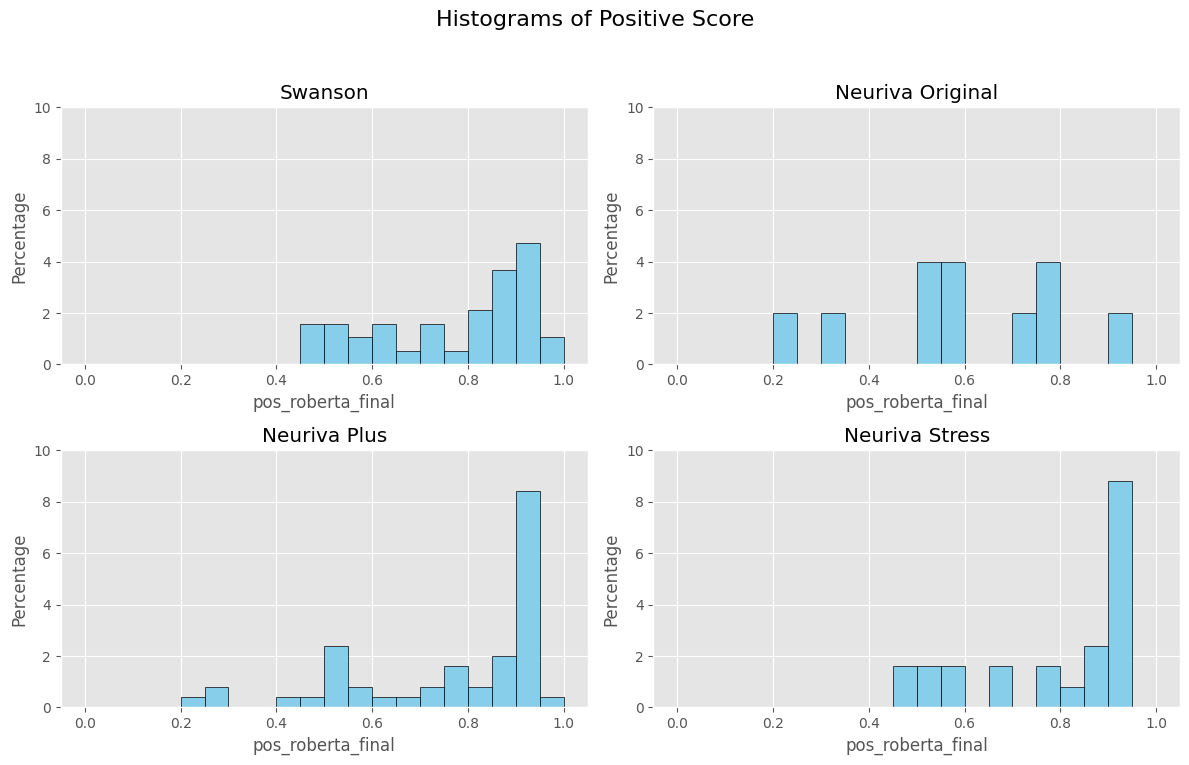

In [169]:
dfs = [swanson_df, neuriva_org_df, neuriva_plus_df, neuriva_stress_df]
labels = ['Swanson', 'Neuriva Original', 'Neuriva Plus', 'Neuriva Stress']

plt.figure(figsize=(12, 8))
plt.suptitle('Histograms of Positive Score', fontsize=16)

for i, df in enumerate(dfs):
    plt.subplot(2, 2, i+1)
    plt.hist(df['pos_roberta_final'], bins=20, range=(0, 1), color='skyblue', edgecolor='black', density=True)
    plt.title(labels[i])
    plt.xlabel('pos_roberta_final')
    plt.ylabel('Percentage')
    plt.ylim(0, 10)  # Set y-axis limit to 10%

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

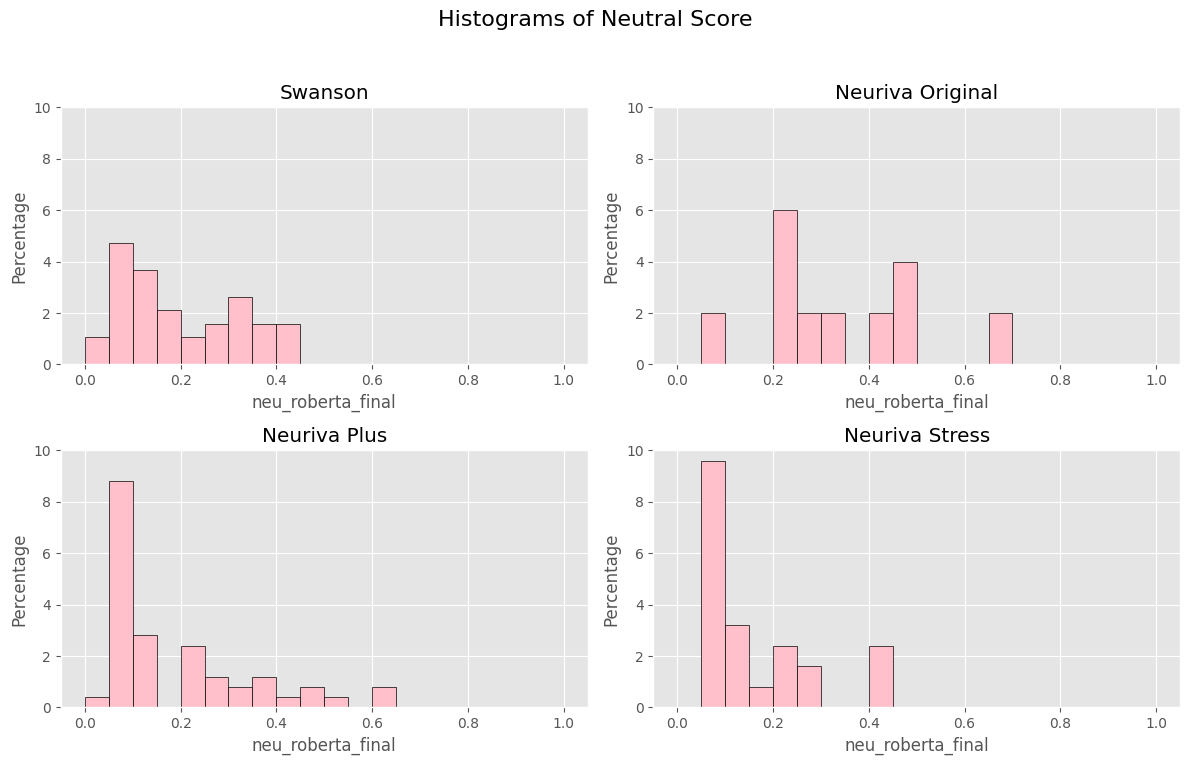

In [142]:
dfs = [swanson_df, neuriva_org_df, neuriva_plus_df, neuriva_stress_df]
labels = ['Swanson', 'Neuriva Original', 'Neuriva Plus', 'Neuriva Stress']

plt.figure(figsize=(12, 8))
plt.suptitle('Histograms of Neutral Score', fontsize=16)

for i, df in enumerate(dfs):
    plt.subplot(2, 2, i+1)
    plt.hist(df['neu_roberta_final'], bins=20, range=(0, 1), color='pink', edgecolor='black', density=True)
    plt.title(labels[i])
    plt.xlabel('neu_roberta_final')
    plt.ylabel('Percentage')
    plt.ylim(0, 10)  # Set y-axis limit to 10%

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

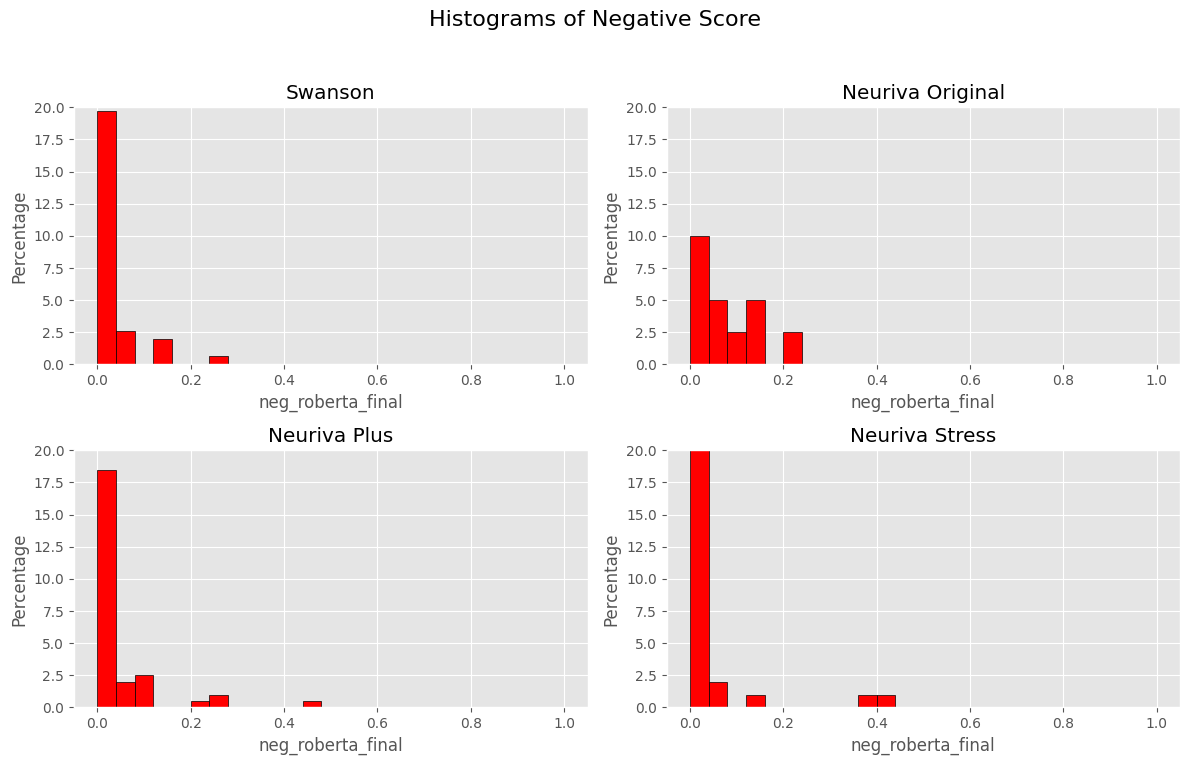

In [143]:
dfs = [swanson_df, neuriva_org_df, neuriva_plus_df, neuriva_stress_df]
labels = ['Swanson', 'Neuriva Original', 'Neuriva Plus', 'Neuriva Stress']

plt.figure(figsize=(12, 8))
plt.suptitle('Histograms of Negative Score', fontsize=16)

for i, df in enumerate(dfs):
    plt.subplot(2, 2, i+1)
    plt.hist(df['neg_roberta_final'], bins=25, range=(0, 1), color='red', edgecolor='black', density=True)
    plt.title(labels[i])
    plt.xlabel('neg_roberta_final')
    plt.ylabel('Percentage')
    plt.ylim(0, 20)  # Set y-axis limit to 10%

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 2.6. Sentiment Label Counts

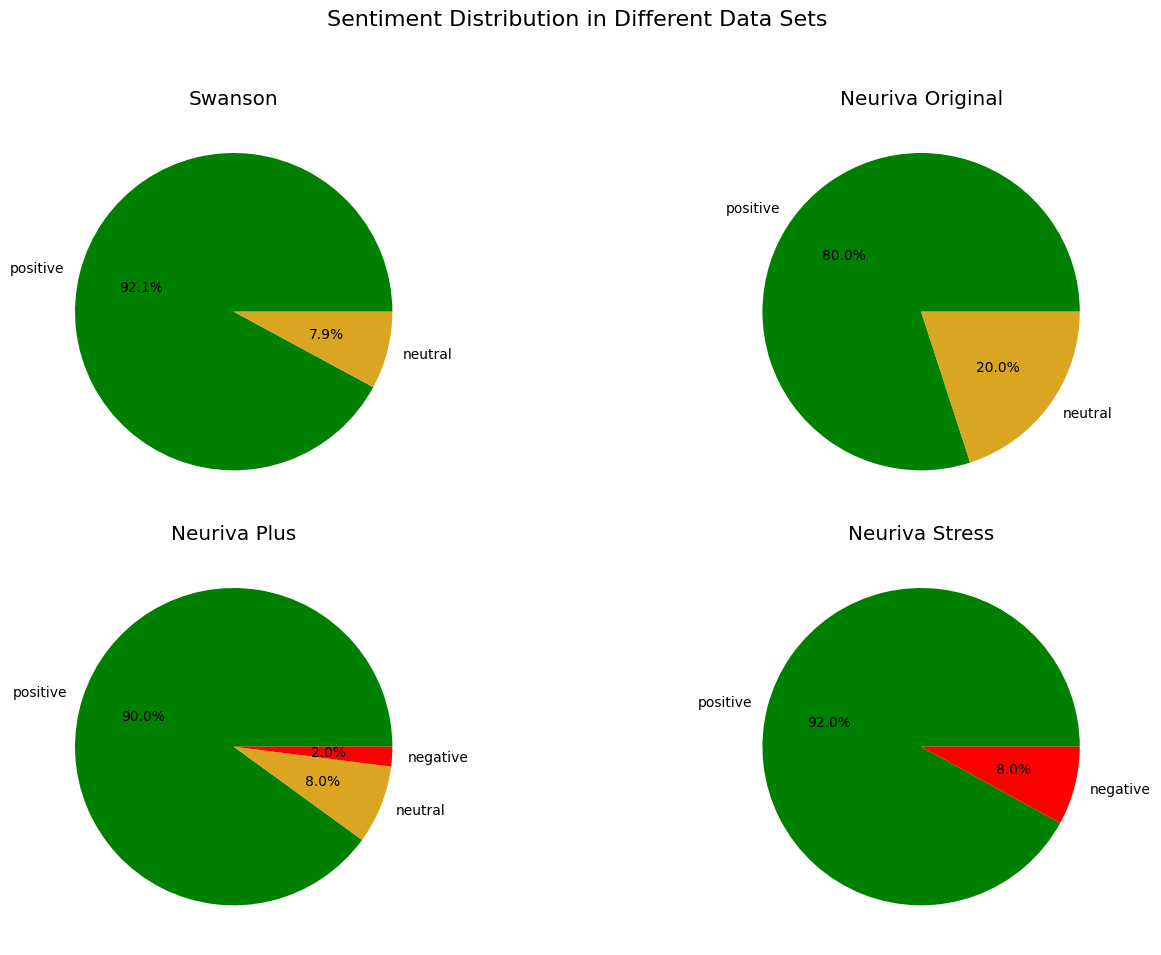

In [172]:
# Define colors for the pie chart
colors = {'positive': 'green', 'neutral': 'goldenrod', 'negative': 'red'}

# Define the data sets
datasets = [swanson_df, neuriva_org_df, neuriva_plus_df, neuriva_stress_df]

# Define the labels
labels = ['Swanson', 'Neuriva Original', 'Neuriva Plus', 'Neuriva Stress']

# Plot pie charts for each dataset
plt.figure(figsize=(15, 10))
plt.suptitle('Sentiment Distribution in Different Data Sets', fontsize=16)

for i, df in enumerate(datasets):
    # Count the occurrences of each label
    counts = df['label'].value_counts()

    # Plot the pie chart
    plt.subplot(2, 2, i+1)
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', colors=[colors[label] for label in counts.index])
    plt.title(labels[i])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Step 3: Finding Recurring Topic Using BERTopic

In [145]:
#pip install tables --force-reinstall --no-deps --no-cache-dir

In [146]:
#pip install hdbscan
#Install this before hdbscan: https://visualstudio.microsoft.com/visual-cpp-build-tools/

In [147]:
pip install bertopic

In [148]:
from bertopic import BERTopic

### 3.1. Swanson

In [149]:
# Analyzing topic, but did not generate any useful, so crossout to lighter the pipeline
# # Initialize BERTopic model with top_n_words set to 8
# model = BERTopic(top_n_words=5)

# # Fit BERTopic model
# topics, _ = model.fit_transform(swanson['review_body'])

# # Get topics
# topics = model.get_topics()

# # Print topics
# for topic_id, words in topics.items():
#     print(f"Topic {topic_id}:")
#     for word, weight in words:
#         print(f"{word}: {weight}")
#     print()

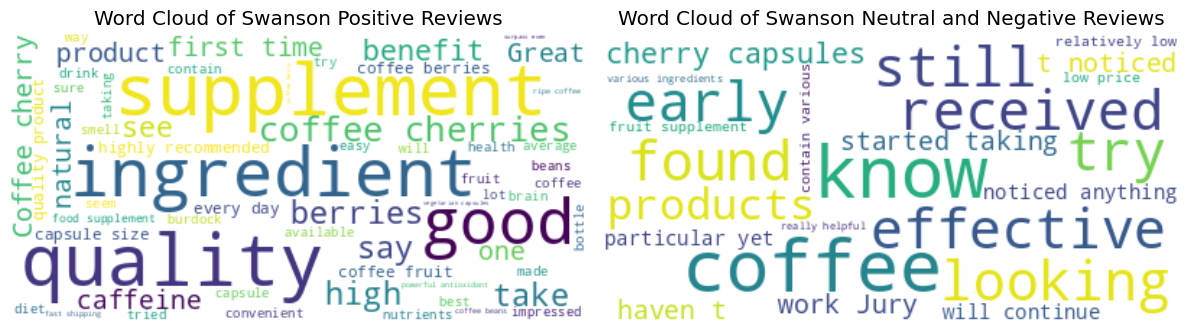

In [150]:
# Filter swanson_df based on label
positive_reviews_swanson = swanson_df[swanson_df['label'] == 'positive']
neutral_reviews_swanson = swanson_df[swanson_df['label'].isin(['neutral', 'negative'])]

# Concatenate all review bodies for each sentiment
text_positive_swanson = " ".join(review for review in positive_reviews_swanson['review_body'])
text_neutral_swanson = " ".join(review for review in neutral_reviews_swanson['review_body'])

# Generate word clouds for each sentiment
wordcloud_positive = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text_positive_swanson)
wordcloud_neutral = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text_neutral_swanson)

# Display the word clouds
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation="bilinear")
plt.title('Word Cloud of Swanson Positive Reviews')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_neutral, interpolation="bilinear")
plt.title('Word Cloud of Swanson Neutral and Negative Reviews')
plt.axis("off")

plt.tight_layout()
plt.show()

### 3.2. Neuriva Original

In [151]:
# Analyzing topic, but did not generate any useful, so crossout to lighter the pipeline
# # Initialize BERTopic model with top_n_words set to 8
# model = BERTopic(top_n_words=5)

# # Fit BERTopic model
# topics, _ = model.fit_transform(neuriva_org['review_body'])

# # Get topics
# topics = model.get_topics()

# # Print topics
# for topic_id, words in topics.items():
#     print(f"Topic {topic_id}:")
#     for word, weight in words:
#         print(f"{word}: {weight}")
#     print()

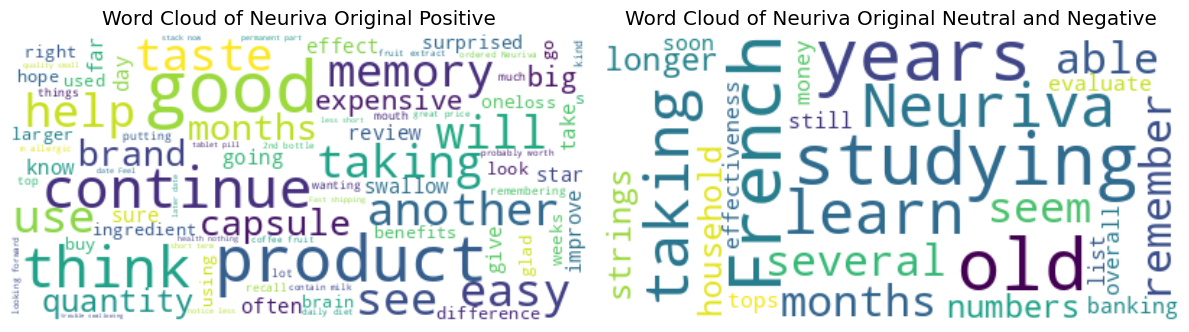

In [152]:
# Filter neuriva_org_df based on label
positive_reviews_neuriva_org = neuriva_org_df[neuriva_org_df['label'] == 'positive']
neutral_reviews_neuriva_org = neuriva_org_df[neuriva_org_df['label'].isin(['neutral', 'negative'])]

# Concatenate all review bodies for each sentiment
text_positive_neuriva_org = " ".join(review for review in positive_reviews_neuriva_org['review_body'])
text_neutral_neuriva_org = " ".join(review for review in neutral_reviews_neuriva_org['review_body'])

# Generate word clouds for each sentiment
wordcloud_positive_neuriva_org = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text_positive_neuriva_org)
wordcloud_neutral_neuriva_org = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text_neutral_neuriva_org)

# Display the word clouds
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive_neuriva_org, interpolation="bilinear")
plt.title('Word Cloud of Neuriva Original Positive')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_neutral_neuriva_org, interpolation="bilinear")
plt.title('Word Cloud of Neuriva Original Neutral and Negative')
plt.axis("off")

plt.tight_layout()
plt.show()

### 3.3. Neuriva Plus

In [153]:
# Analyzing topic, but did not generate any useful, so crossout to lighter the pipeline
# # Initialize BERTopic model with top_n_words set to 8
# model = BERTopic(top_n_words=5)

# # Fit BERTopic model
# topics, _ = model.fit_transform(neuriva_plus['review_body'])

# # Get topics
# topics = model.get_topics()

# # Print topics
# for topic_id, words in topics.items():
#     print(f"Topic {topic_id}:")
#     for word, weight in words:
#         print(f"{word}: {weight}")
#     print()

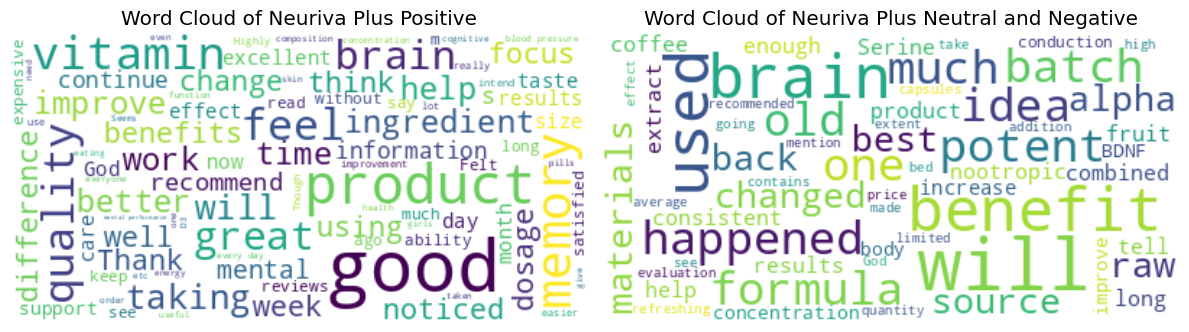

In [154]:
# Filter neuriva_plus_df based on label
positive_reviews_neuriva_plus = neuriva_plus_df[neuriva_plus_df['label'] == 'positive']
neutral_reviews_neuriva_plus = neuriva_plus_df[neuriva_plus_df['label'].isin(['neutral', 'negative'])]

# Concatenate all review bodies for each sentiment
text_positive_neuriva_plus = " ".join(review for review in positive_reviews_neuriva_plus['review_body'])
text_neutral_neuriva_plus = " ".join(review for review in neutral_reviews_neuriva_plus['review_body'])

# Generate word clouds for each sentiment
wordcloud_positive_neuriva_plus = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text_positive_neuriva_plus)
wordcloud_neutral_neuriva_plus = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text_neutral_neuriva_plus)

# Display the word clouds
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive_neuriva_plus, interpolation="bilinear")
plt.title('Word Cloud of Neuriva Plus Positive')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_neutral_neuriva_plus, interpolation="bilinear")
plt.title('Word Cloud of Neuriva Plus Neutral and Negative')
plt.axis("off")

plt.tight_layout()
plt.show()

### 3.4. Neuriva Destress

In [155]:
# Analyzing topic, but did not generate any useful, so crossout to lighter the pipeline

# # Initialize BERTopic model with top_n_words set to 8
# model = BERTopic(top_n_words=5)

# # Fit BERTopic model
# topics, _ = model.fit_transform(neuriva_stress['review_body'])

# # Get topics
# topics = model.get_topics()

# # Print topics
# for topic_id, words in topics.items():
#     print(f"Topic {topic_id}:")
#     for word, weight in words:
#         print(f"{word}: {weight}")
#     print()

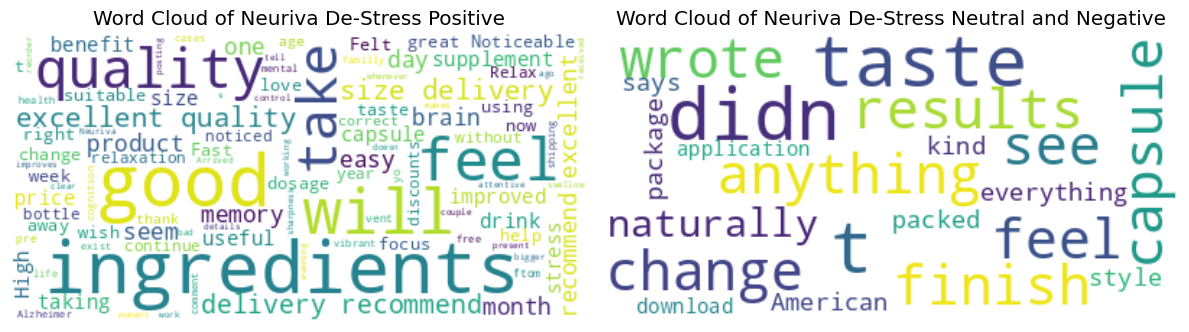

In [156]:
# Filter neuriva_stress_df based on label
positive_reviews_neuriva_stress = neuriva_stress_df[neuriva_stress_df['label'] == 'positive']
neutral_reviews_neuriva_stress = neuriva_stress_df[neuriva_stress_df['label'].isin(['neutral', 'negative'])]

# Concatenate all review bodies for each sentiment
text_positive_neuriva_stress = " ".join(review for review in positive_reviews_neuriva_stress['review_body'])
text_neutral_neuriva_stress = " ".join(review for review in neutral_reviews_neuriva_stress['review_body'])

# Generate word clouds for each sentiment
wordcloud_positive_neuriva_stress = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text_positive_neuriva_stress)
wordcloud_neutral_neuriva_stress = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text_neutral_neuriva_stress)

# Display the word clouds
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive_neuriva_stress, interpolation="bilinear")
plt.title('Word Cloud of Neuriva De-Stress Positive')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_neutral_neuriva_stress, interpolation="bilinear")
plt.title('Word Cloud of Neuriva De-Stress Neutral and Negative')
plt.axis("off")

plt.tight_layout()
plt.show()

In [157]:
# sns.pairplot(data=results_df,
#              vars=['vader_neg', 'vader_neu', 'vader_pos',
#                   'roberta_neg', 'roberta_neu', 'roberta_pos'],
#             palette='tab10')
# plt.show()

# Step 4: Error Reviews

## Positive score but low rating - False Positive

In [158]:
result = final_results_df.query('rating == 1') \
                   .sort_values('pos_roberta_final', ascending=False) \
                   [['review_body', 'neg_roberta_final', 'neu_roberta_final', 'pos_roberta_final', 'title']] \
                   .iloc[0]

review_body = result['review_body']
roberta_neg = result['neg_roberta_final']
roberta_neu = result['neu_roberta_final']
roberta_pos = result['pos_roberta_final']

print("Review Body:", review_body)
print("RoBERTa Negative Score:", roberta_neg)
print("RoBERTa Neutral Score:", roberta_neu)
print("RoBERTa Positive Score:", roberta_pos)

Review Body: I didn’t do anything for me I finish it but Didn’t see any results
RoBERTa Negative Score: 0.39643460838124156
RoBERTa Neutral Score: 0.1505017653107643
RoBERTa Positive Score: 0.4530636081472039


## Negative 5 star review - False Negative

In [159]:
result = final_results_df.query('rating == 5') \
                   .sort_values('neg_roberta_final', ascending=False) \
                   [['review_body', 'neg_roberta_final', 'neu_roberta_final', 'pos_roberta_final', 'title']] \
                   .iloc[0]

review_body = result['review_body']
roberta_neg = result['neg_roberta_final']
roberta_neu = result['neu_roberta_final']
roberta_pos = result['pos_roberta_final']

print("Review Body:", review_body)
print("RoBERTa Negative Score:", roberta_neg)
print("RoBERTa Neutral Score:", roberta_neu)
print("RoBERTa Positive Score:", roberta_pos)

Review Body: Good product for memory. I gave it to my mother who had a stroke in her left eye, and the other day I asked her about the pills and she told me that they worked quite well for her, she even noticed that she looked better. For now he will continue taking them as they have given him good results. For me, very happy with the purchase. Thank you.
RoBERTa Negative Score: 0.2734961338574067
RoBERTa Neutral Score: 0.22319186199456453
RoBERTa Positive Score: 0.5033120028674603
